# Import

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import cv2
import math
import copy
import torch
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.fk_module import GraceLitModule
from src.models.components.fk_net import FKNet
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import mse_loss

import pytransform3d
import pytransform3d.camera as pc
from pytransform3d import rotations as pr
import pytransform3d.transformations as pt
from pytransform3d.plot_utils import make_3d_axis, plot_vector

# Helper Functions

In [2]:
torch.set_default_device('cuda')
torch.set_default_dtype(d=torch.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

MAX_METER_VALUE = 1.5
MAX_DEG_VALUE = 44
MAX_RVEC_VALUE = 1.5708

def min_max_scaler(arr, min_val, max_val):
    scaled_arr = 2 * (arr - min_val) / (max_val - min_val) - 1
    return scaled_arr

def vec2homo(rvec,tvec):
    # Convert the rotation vector to a rotation matrix
    rotation_matrix, _ = cv2.Rodrigues(rvec)

    # Homogeneous Coordinates (H = Tbc =T_board2cam)
    T = np.eye(4)
    T[:3,:3] = rotation_matrix
    T[:3,-1] = tvec.flatten()
    
    return T

def preprocess_csv(data_dir, val_size=0.3, seed=75):
    # Read CSV
    df = pd.read_csv(data_dir)

    # Reorganizing DataFrame
    data_df = pd.DataFrame({
        # Input
        'cmd_lnt_t': df['cmd_theta_lower_neck_tilt'].values,
        'cmd_lnp_t': df['cmd_theta_lower_neck_pan'].values,
        'cmd_unt_t': df['cmd_theta_upper_neck_tilt'].values,
        'cmd_et_t': df['cmd_theta_eyes_tilt'].values,
        'cmd_lep_t': df['cmd_theta_left_eye_pan'].values,
        'cmd_rep_t': df['cmd_theta_right_eye_pan'].values,

        # Targets
        'l_rvec_0': df['l_rvec_0'].values,
        'l_rvec_1': df['l_rvec_1'].values,
        'l_rvec_2': df['l_rvec_2'].values,
        'l_tvec_0': df['l_tvec_0'].values,
        'l_tvec_1': df['l_tvec_1'].values,
        'l_tvec_2': df['l_tvec_2'].values,
        'r_rvec_0': df['r_rvec_0'].values,
        'r_rvec_1': df['r_rvec_1'].values,
        'r_rvec_2': df['r_rvec_2'].values,
        'r_tvec_0': df['r_tvec_0'].values,
        'r_tvec_1': df['r_tvec_1'].values,
        'r_tvec_2': df['r_tvec_2'].values,
    })

    # Minmax Feature Scaler
    feature_ranges = {
        'cmd_lnt_t': (-44, 44),
        'cmd_lnp_t': (-44, 44),
        'cmd_unt_t': (-44, 44),
        'cmd_et_t': (-44, 44),
        'cmd_lep_t': (-44, 44),
        'cmd_rep_t': (-44, 44),
        'l_rvec_0': (-1.5708, 1.5708),
        'l_rvec_1': (-1.5708, 1.5708),
        'l_rvec_2': (-1.5708, 1.5708),
        'l_tvec_0': (-1.5, 1.5),  
        'l_tvec_1': (-1.5, 1.5),  
        'l_tvec_2': (-1.5, 1.5),
        'r_rvec_0': (-1.5708, 1.5708),
        'r_rvec_1': (-1.5708, 1.5708),
        'r_rvec_2': (-1.5708, 1.5708),
        'r_tvec_0': (-1.5, 1.5),
        'r_tvec_1': (-1.5, 1.5),  
        'r_tvec_2': (-1.5, 1.5),
    }
    
    # All Dataset
    all_df = data_df.copy()

    # Separation of Training and Validation Set
    train_df, temp_df = train_test_split(data_df, test_size=val_size, random_state=seed)
    val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=seed)

    # Training Set
    X_train = torch.tensor(train_df.iloc[:,:6].values, dtype=torch.float32)
    y_train = torch.tensor(train_df.iloc[:,6:].values, dtype=torch.float32)
    train_dataset = TensorDataset(X_train, y_train)

    # Validation Set
    X_val = torch.tensor(val_df.iloc[:,:6].values, dtype=torch.float32)
    y_val = torch.tensor(val_df.iloc[:,6:].values, dtype=torch.float32)
    val_dataset = TensorDataset(X_val, y_val)

    # Test Set
    X_test = torch.tensor(test_df.iloc[:,:6].values, dtype=torch.float32)
    y_test = torch.tensor(test_df.iloc[:,6:].values, dtype=torch.float32)
    test_dataset = TensorDataset(X_test, y_test)
    
    # Scaled All Set
    scaled_all_df = all_df.copy()
    for col in all_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_all_df[col] = 2 * (all_df[col] - col_min) / (col_max - col_min) - 1
    
    # Scaled Train Set
    scaled_train_df = train_df.copy()
    for col in train_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_train_df[col] = 2 * (train_df[col] - col_min) / (col_max - col_min) - 1
        
    # Scaled Val Set
    scaled_val_df = val_df.copy()
    for col in val_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_val_df[col] = 2 * (val_df[col] - col_min) / (col_max - col_min) - 1
    
    # Scaled Test Set
    scaled_test_df = test_df.copy()
    for col in test_df[feature_ranges.keys()].columns:
        col_min, col_max = feature_ranges[col]
        scaled_test_df[col] = 2 * (test_df[col] - col_min) / (col_max - col_min) - 1

    return all_df, train_df, val_df, test_df, scaled_all_df, scaled_train_df, scaled_val_df, scaled_test_df


# Error Histogram

In [3]:
csv_fn = '/home/jaynieles/dev/grace_dl/logs/sfk/multiruns/2024-10-25_05-16-23/0/tensorboard/version_0/delta_output_analysis.csv'
csv_df = pd.read_csv(csv_fn)

## Left Camera

Text(0.5, 1.0, 'Left Rvec 0')

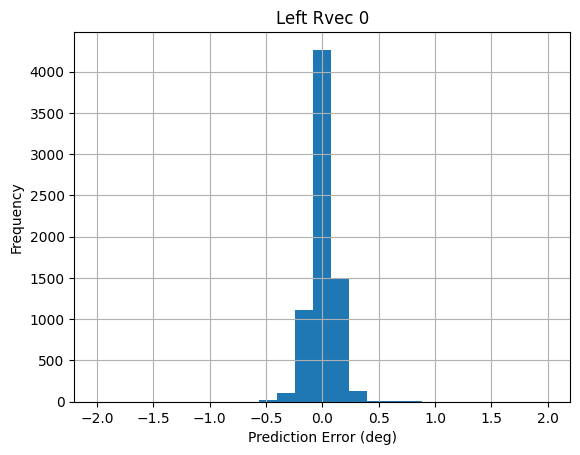

In [4]:
plt.figure()
plt.hist(np.degrees(csv_df['delta_l_rvec_0']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Rvec 0')

Text(0.5, 1.0, 'Left Rvec 1')

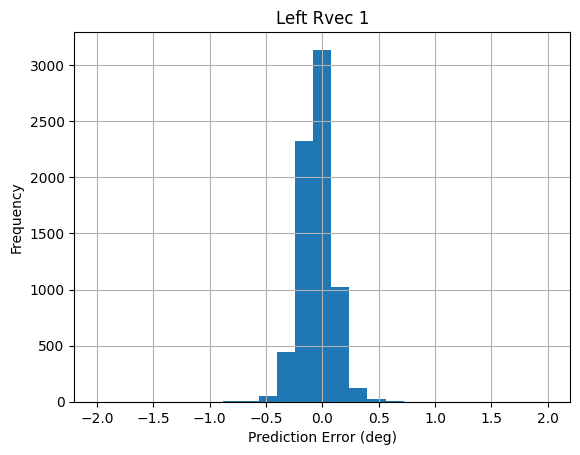

In [5]:
plt.hist(np.degrees(csv_df['delta_l_rvec_1']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Rvec 1')

Text(0.5, 1.0, 'Left Rvec 2')

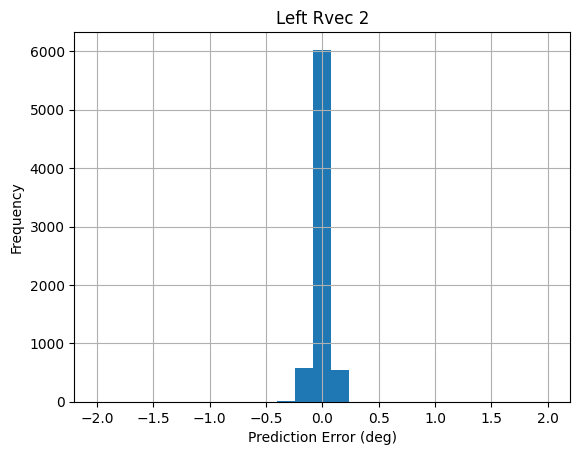

In [6]:
plt.hist(np.degrees(csv_df['delta_l_rvec_2']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Rvec 2')

Text(0.5, 1.0, 'Left Tvec 0')

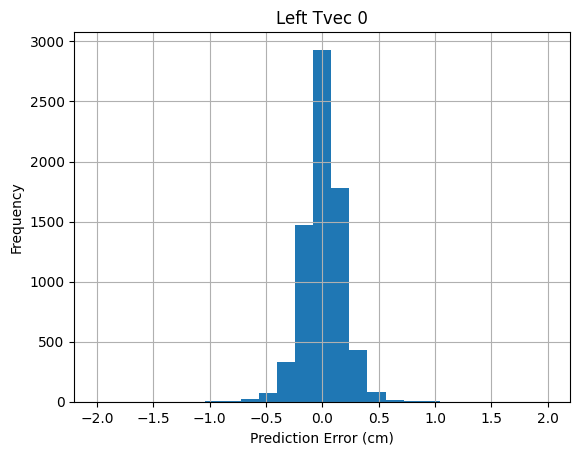

In [7]:
plt.hist(100*csv_df['delta_l_tvec_0'], bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Left Tvec 0')

Text(0.5, 1.0, 'Left Tvec 1')

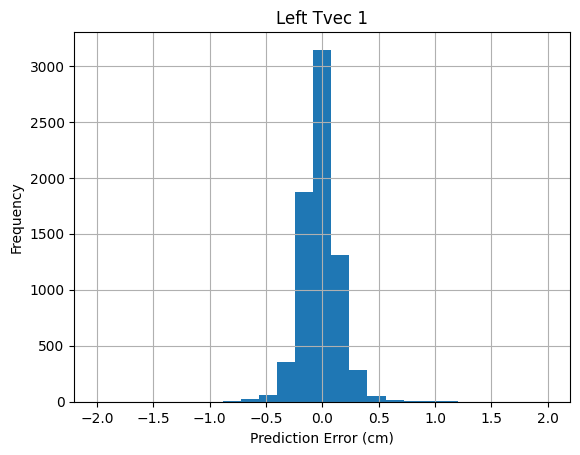

In [8]:
plt.hist(100*csv_df['delta_l_tvec_1'], bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Left Tvec 1')

Text(0.5, 1.0, 'Left Tvec 2')

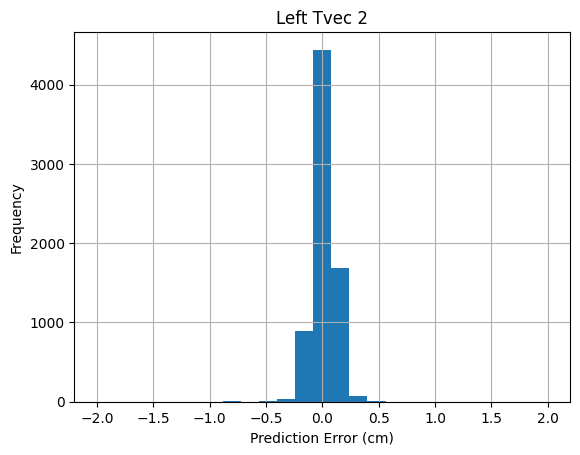

In [9]:
plt.hist(100*csv_df['delta_l_tvec_2'], bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Left Tvec 2')

## Right Camera

Text(0.5, 1.0, 'Right Rvec 0')

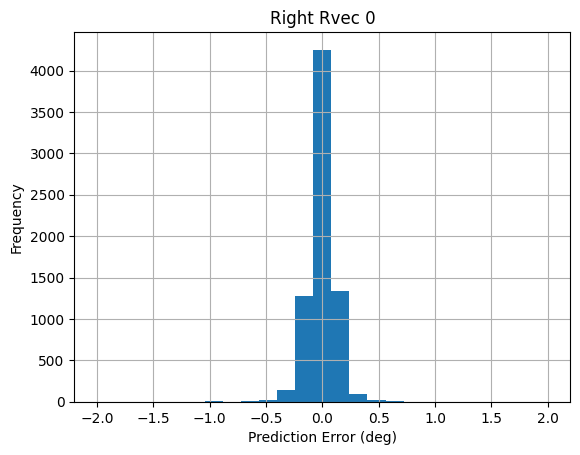

In [10]:
plt.hist(np.degrees(csv_df['delta_r_rvec_0']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Rvec 0')

Text(0.5, 1.0, 'Right Rvec 1')

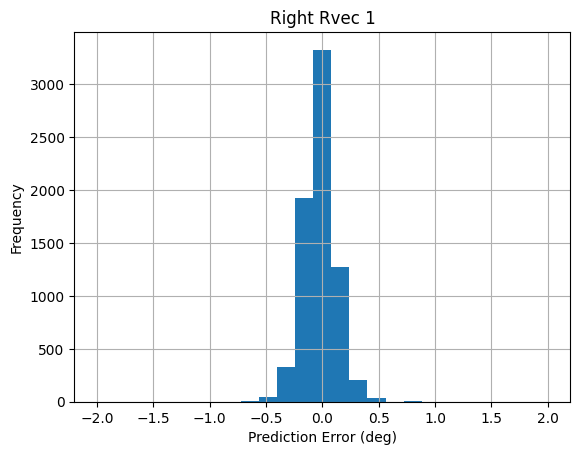

In [11]:
plt.hist(np.degrees(csv_df['delta_r_rvec_1']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Rvec 1')

Text(0.5, 1.0, 'Right Rvec 2')

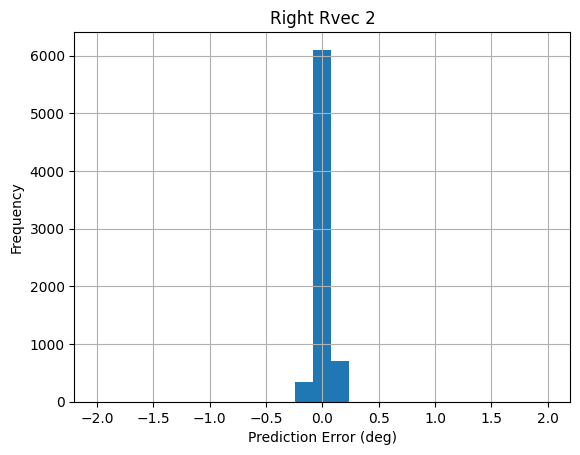

In [12]:
plt.hist(np.degrees(csv_df['delta_r_rvec_2']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Rvec 2')

Text(0.5, 1.0, 'Right Tvec 0')

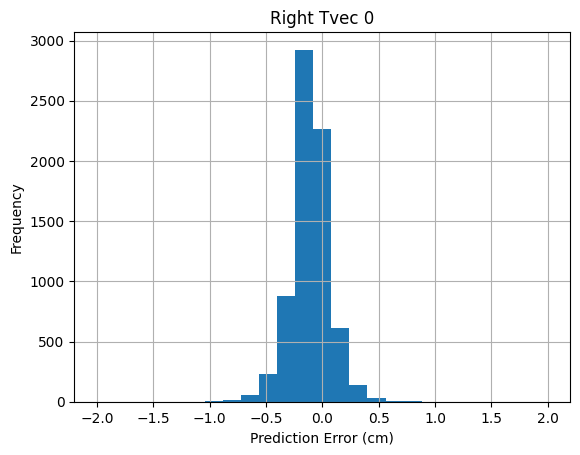

In [13]:
plt.hist(100*csv_df['delta_r_tvec_0'], bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Right Tvec 0')

Text(0.5, 1.0, 'Right Tvec 1')

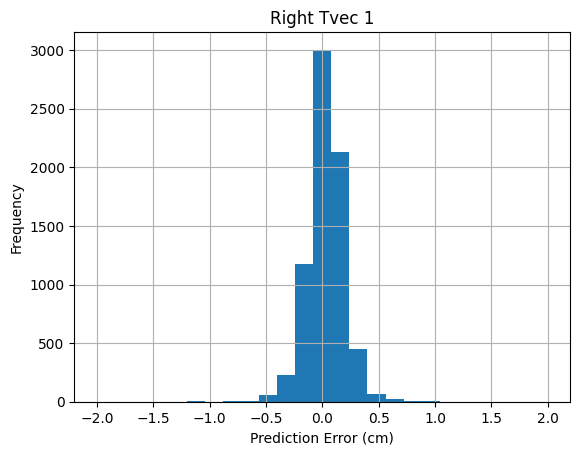

In [14]:
plt.hist(100*csv_df['delta_r_tvec_1'], bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Right Tvec 1')

Text(0.5, 1.0, 'Right Tvec 2')

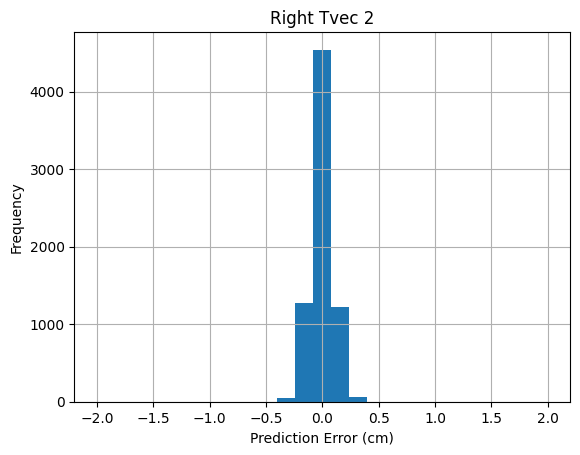

In [15]:
plt.hist(100*csv_df['delta_r_tvec_2'], bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (cm)')
plt.ylabel('Frequency')
plt.title('Right Tvec 2')

# Error Table

In [16]:
results_idx = ['r(deg)','p(deg)', 'y(deg)', 'x(cm)','y(cm)', 'z(cm)',]
results_df = pd.DataFrame({'Left Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_0'].values),torch.Tensor(100*csv_df['target_l_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_1'].values),torch.Tensor(100*csv_df['target_l_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_2'].values),torch.Tensor(100*csv_df['target_l_tvec_2'].values)).cpu().item()),
                            ],
                          'Right Eye RMSE': [
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_0'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_1'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_2'].values))).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_0'].values),torch.Tensor(100*csv_df['target_r_tvec_0'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_1'].values),torch.Tensor(100*csv_df['target_r_tvec_1'].values)).cpu().item()),
                            math.sqrt(mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_2'].values),torch.Tensor(100*csv_df['target_r_tvec_2'].values)).cpu().item()),
                          ],
                          'Left Eye MSE': [
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_0'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_1'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_l_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_l_rvec_2'].values))).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_0'].values),torch.Tensor(100*csv_df['target_l_tvec_0'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_1'].values),torch.Tensor(100*csv_df['target_l_tvec_1'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_l_tvec_2'].values),torch.Tensor(100*csv_df['target_l_tvec_2'].values)).cpu().item(),
                            ],
                          'Right Eye MSE': [
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_0'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_0'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_1'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_1'].values))).cpu().item(),
                            mse_loss(torch.Tensor(np.degrees(csv_df['pred_r_rvec_2'].values)),torch.Tensor(np.degrees(csv_df['target_r_rvec_2'].values))).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_0'].values),torch.Tensor(100*csv_df['target_r_tvec_0'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_1'].values),torch.Tensor(100*csv_df['target_r_tvec_1'].values)).cpu().item(),
                            mse_loss(torch.Tensor(100*csv_df['pred_r_tvec_2'].values),torch.Tensor(100*csv_df['target_r_tvec_2'].values)).cpu().item(),
                            ],
                          })
results_df.index = results_idx
results_df

,Left Eye RMSE,Right Eye RMSE,Left Eye MSE,Right Eye MSE
r(deg),0.115278,0.114597,0.013289,0.013132
p(deg),0.157567,0.146450,0.024827,0.021447
y(deg),0.058355,0.056127,0.003405,0.003150
x(cm),0.181316,0.197763,0.032875,0.039110
y(cm),0.165601,0.166346,0.027424,0.027671
z(cm),0.099660,0.093474,0.009932,0.008737


# 3D Plot

In [17]:
# Input
idx = 0

# Left Camera
pred_l_rvec = np.array([csv_df['pred_l_rvec_0'][idx],csv_df['pred_l_rvec_1'][idx],csv_df['pred_l_rvec_2'][idx]])
pred_l_tvec = np.array([csv_df['pred_l_tvec_0'][idx],csv_df['pred_l_tvec_1'][idx],csv_df['pred_l_tvec_2'][idx]])
target_l_rvec =  np.array([csv_df['target_l_rvec_0'][idx],csv_df['target_l_rvec_1'][idx],csv_df['target_l_rvec_2'][idx]])
target_l_tvec = np.array([csv_df['target_l_tvec_0'][idx],csv_df['target_l_tvec_1'][idx],csv_df['target_l_tvec_2'][idx]])
pred_l_homo = vec2homo(pred_l_rvec, pred_l_tvec)
target_l_homo = vec2homo(target_l_rvec, target_l_tvec)
pred_l_homo_inv = np.linalg.inv(pred_l_homo)
target_l_homo_inv = np.linalg.inv(target_l_homo)

# Right Camera
pred_r_rvec = np.array([csv_df['pred_r_rvec_0'][idx],csv_df['pred_r_rvec_1'][idx],csv_df['pred_r_rvec_2'][idx]])
pred_r_tvec = np.array([csv_df['pred_r_tvec_0'][idx],csv_df['pred_r_tvec_1'][idx],csv_df['pred_r_tvec_2'][idx]])
target_r_rvec =  np.array([csv_df['target_r_rvec_0'][idx],csv_df['target_r_rvec_1'][idx],csv_df['target_r_rvec_2'][idx]])
target_r_tvec = np.array([csv_df['target_r_tvec_0'][idx],csv_df['target_r_tvec_1'][idx],csv_df['target_r_tvec_2'][idx]])
pred_r_homo = vec2homo(pred_r_rvec, pred_r_tvec)
target_r_homo = vec2homo(target_r_rvec, target_r_tvec)
pred_r_homo_inv = np.linalg.inv(pred_r_homo)
target_r_homo_inv = np.linalg.inv(target_r_homo)

print('Pred Left Cam:', pred_l_homo)
print('Target Left Cam:', target_l_homo)
print('Pred Right Cam:', pred_r_homo)
print('Target Right Cam:', target_r_homo)

Pred Left Cam: [[ 0.82428087 -0.00886462  0.5661117   0.01854862]
 [-0.08598048  0.98632094  0.14063555  0.22418211]
 [-0.55961451 -0.16459775  0.8122433  -0.06049881]
 [ 0.          0.          0.          1.        ]]
Target Left Cam: [[ 0.82499022 -0.00962712  0.565065    0.01924337]
 [-0.08573448  0.98615075  0.14197286  0.22282383]
 [-0.55860606 -0.16557177  0.81273935 -0.06025553]
 [ 0.          0.          0.          1.        ]]
Pred Right Cam: [[ 0.95905424  0.02263567  0.28231646 -0.02388079]
 [-0.0736691   0.98242744  0.17149109  0.22030345]
 [-0.27347362 -0.18526726  0.94386875 -0.05558553]
 [ 0.          0.          0.          1.        ]]
Target Right Cam: [[ 0.95833242  0.02234404  0.28478014 -0.02681134]
 [-0.07393067  0.98236926  0.17171164  0.22082856]
 [-0.27592252 -0.18561081  0.94308822 -0.05558811]
 [ 0.          0.          0.          1.        ]]


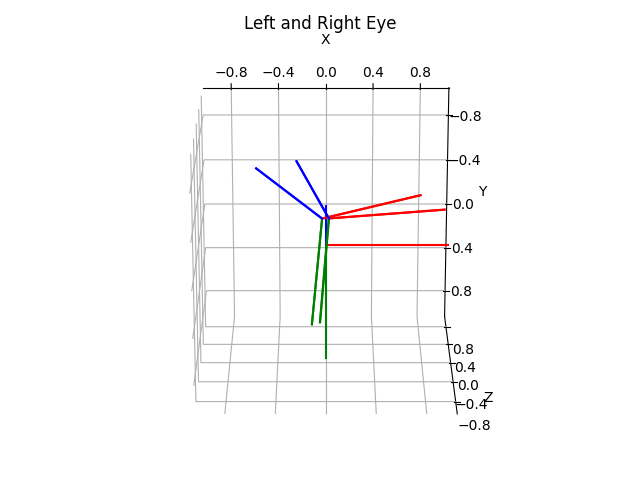

In [18]:
%matplotlib widget

# Plot
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = pr.plot_basis()

# Left Camera
ax = pr.plot_basis(R=pred_l_homo_inv[:3,:3], p=pred_l_homo_inv[:3,3].flatten())
ax = pr.plot_basis(R=target_l_homo_inv[:3,:3], p=target_l_homo_inv[:3,3].flatten())

# Right Camera
ax = pr.plot_basis(R=pred_r_homo_inv[:3,:3], p=pred_r_homo_inv[:3,3].flatten())
ax = pr.plot_basis(R=target_r_homo_inv[:3,:3], p=target_r_homo_inv[:3,3].flatten())

ax.view_init(elev=-70, azim=-90, roll=0)
ax.set_title('Left and Right Eye')
plt.tight_layout()

# Load ANN Model

In [19]:
ckpt_path = '/home/jaynieles/dev/grace_dl/logs/sfk/multiruns/2024-10-25_05-16-23/0/checkpoints/epoch_241.ckpt'

In [20]:
model = GraceLitModule.load_from_checkpoint(ckpt_path)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


# Load Another Test Dataset

In [21]:
dataset_fn = "/home/jaynieles/dev/grace_dl/data/thesis/241005_075m_test_grace_dataset_1000.csv"
all_df,train_df,val_df,test_df,scaled_all_df,scaled_train_df,scaled_val_df,scaled_test_df = preprocess_csv(dataset_fn)

In [40]:
dataset_fn = "/home/jaynieles/dev/grace_dl/data/thesis/241010_best_075m_grace_dataset_1000.csv"
all_df,train_df,val_df,test_df,scaled_all_df,scaled_train_df,scaled_val_df,scaled_test_df = preprocess_csv(dataset_fn)

In [41]:
# Tensor Set

X_all = torch.tensor(scaled_all_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_all = torch.tensor(scaled_all_df.iloc[:,6:].values, dtype=torch.float32, device=device)
X_train = torch.tensor(scaled_train_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_train = torch.tensor(scaled_train_df.iloc[:,6:].values, dtype=torch.float32, device=device)
X_val = torch.tensor(scaled_val_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_val = torch.tensor(scaled_val_df.iloc[:,6:].values, dtype=torch.float32, device=device)
X_test = torch.tensor(scaled_test_df.iloc[:,:6].values, dtype=torch.float32, device=device)
y_test = torch.tensor(scaled_test_df.iloc[:,6:].values, dtype=torch.float32, device=device)

In [42]:
# Model Evaluation
model.eval()
# Output of DNN
with torch.no_grad():
    preds = model(X_all)

In [43]:
# Organizing Results for analysis
inputs_arr = X_all.detach().cpu().numpy()
preds_arr = preds.detach().cpu().numpy()
targets_arr = y_all.detach().cpu().numpy()

# Reorganizing DataFrame
data_df = pd.DataFrame({
    'cmd_lnt_t': MAX_DEG_VALUE*inputs_arr[:,0],
    'cmd_lnp_t': MAX_DEG_VALUE*inputs_arr[:,1],
    'cmd_unt_t': MAX_DEG_VALUE*inputs_arr[:,2],
    'cmd_et_t': MAX_DEG_VALUE*inputs_arr[:,3],
    'cmd_lep_t': MAX_DEG_VALUE*inputs_arr[:,4],
    'cmd_rep_t': MAX_DEG_VALUE*inputs_arr[:,5],

    'target_l_rvec_0': MAX_RVEC_VALUE*targets_arr[:,0],
    'target_l_rvec_1': MAX_RVEC_VALUE*targets_arr[:,1],
    'target_l_rvec_2': MAX_RVEC_VALUE*targets_arr[:,2],
    'target_l_tvec_0': MAX_METER_VALUE*targets_arr[:,3],
    'target_l_tvec_1': MAX_METER_VALUE*targets_arr[:,4],
    'target_l_tvec_2': MAX_METER_VALUE*targets_arr[:,5],
    'target_r_rvec_0': MAX_RVEC_VALUE*targets_arr[:,6],
    'target_r_rvec_1': MAX_RVEC_VALUE*targets_arr[:,7],
    'target_r_rvec_2': MAX_RVEC_VALUE*targets_arr[:,8],
    'target_r_tvec_0': MAX_METER_VALUE*targets_arr[:,9],
    'target_r_tvec_1': MAX_METER_VALUE*targets_arr[:,10],
    'target_r_tvec_2': MAX_METER_VALUE*targets_arr[:,11],

    'pred_l_rvec_0': MAX_RVEC_VALUE*preds_arr[:,0],
    'pred_l_rvec_1': MAX_RVEC_VALUE*preds_arr[:,1],
    'pred_l_rvec_2': MAX_RVEC_VALUE*preds_arr[:,2],
    'pred_l_tvec_0': MAX_METER_VALUE*preds_arr[:,3],
    'pred_l_tvec_1': MAX_METER_VALUE*preds_arr[:,4],
    'pred_l_tvec_2': MAX_METER_VALUE*preds_arr[:,5],
    'pred_r_rvec_0': MAX_RVEC_VALUE*preds_arr[:,6],
    'pred_r_rvec_1': MAX_RVEC_VALUE*preds_arr[:,7],
    'pred_r_rvec_2': MAX_RVEC_VALUE*preds_arr[:,8],
    'pred_r_tvec_0': MAX_METER_VALUE*preds_arr[:,9],
    'pred_r_tvec_1': MAX_METER_VALUE*preds_arr[:,10],
    'pred_r_tvec_2': MAX_METER_VALUE*preds_arr[:,11],
})

# Delta Analysis
data_df['delta_l_rvec_0'] = data_df['target_l_rvec_0'].values - data_df['pred_l_rvec_0'].values
data_df['delta_l_rvec_1'] = data_df['target_l_rvec_1'].values - data_df['pred_l_rvec_1'].values
data_df['delta_l_rvec_2'] = data_df['target_l_rvec_2'].values - data_df['pred_l_rvec_2'].values
data_df['delta_l_tvec_0'] = data_df['target_l_tvec_0'].values - data_df['pred_l_tvec_0'].values
data_df['delta_l_tvec_1'] = data_df['target_l_tvec_1'].values - data_df['pred_l_tvec_1'].values
data_df['delta_l_tvec_2'] = data_df['target_l_tvec_2'].values - data_df['pred_l_tvec_2'].values
data_df['delta_r_rvec_0'] = data_df['target_r_rvec_0'].values - data_df['pred_r_rvec_0'].values
data_df['delta_r_rvec_1'] = data_df['target_r_rvec_1'].values - data_df['pred_r_rvec_1'].values
data_df['delta_r_rvec_2'] = data_df['target_r_rvec_2'].values - data_df['pred_r_rvec_2'].values
data_df['delta_r_tvec_0'] = data_df['target_r_tvec_0'].values - data_df['pred_r_tvec_0'].values
data_df['delta_r_tvec_1'] = data_df['target_r_tvec_1'].values - data_df['pred_r_tvec_1'].values
data_df['delta_r_tvec_2'] = data_df['target_r_tvec_2'].values - data_df['pred_r_tvec_2'].values

Text(0.5, 1.0, 'Left Rvec 0')

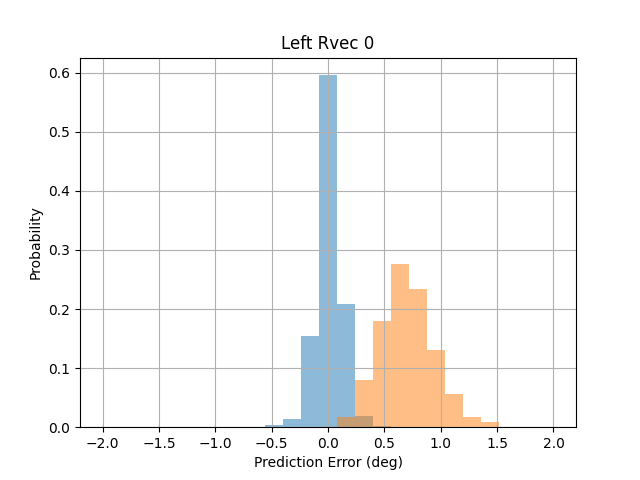

In [44]:
plt.figure()

# Create a histogram with Seaborn
sns.histplot(np.degrees(csv_df['delta_l_rvec_0']), bins=25, stat='probability', kde=False, alpha=0.5, binrange=(-2,2), edgecolor=None)
sns.histplot(np.degrees(data_df['delta_l_rvec_0']), bins=25, stat='probability', kde=False, alpha=0.5, binrange=(-2,2), edgecolor=None)

plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Probability')
plt.title('Left Rvec 0')

Text(0.5, 1.0, 'Left Rvec 0')

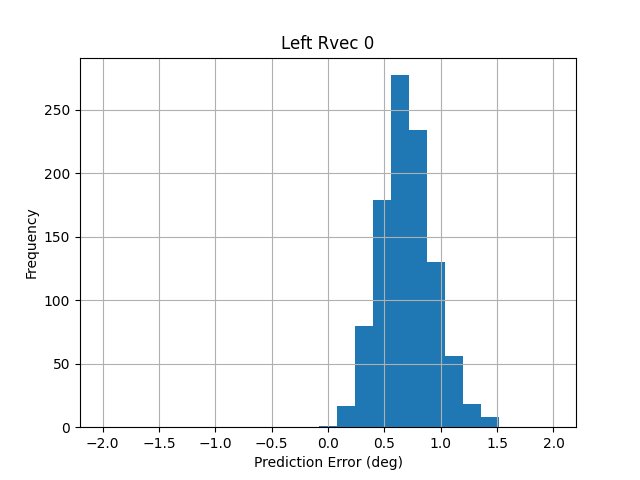

In [45]:
plt.figure()
plt.hist(np.degrees(data_df['delta_l_rvec_0']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Rvec 0')

Text(0.5, 1.0, 'Left Rvec 1')

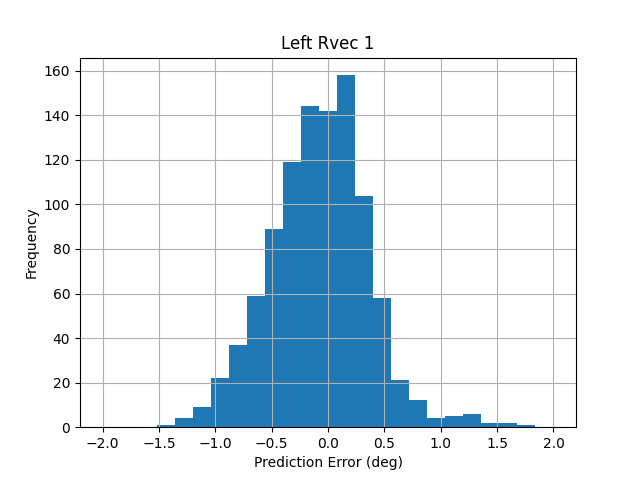

In [46]:
plt.figure()
plt.hist(np.degrees(data_df['delta_l_rvec_1']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Rvec 1')

Text(0.5, 1.0, 'Left Rvec 2')

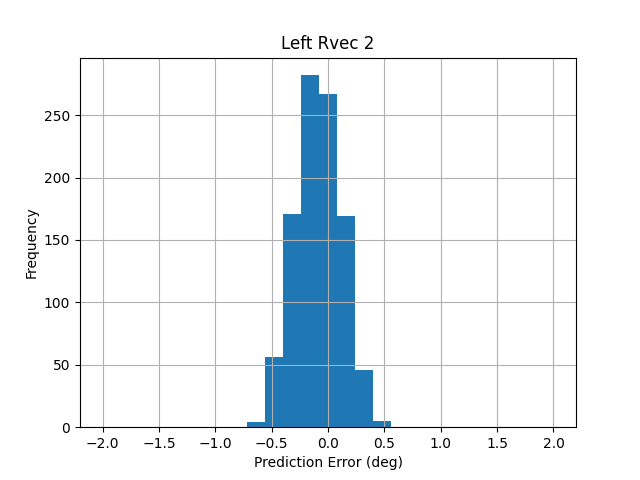

In [47]:
plt.figure()
plt.hist(np.degrees(data_df['delta_l_rvec_2']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Rvec 2')

Text(0.5, 1.0, 'Left Tvec 0')

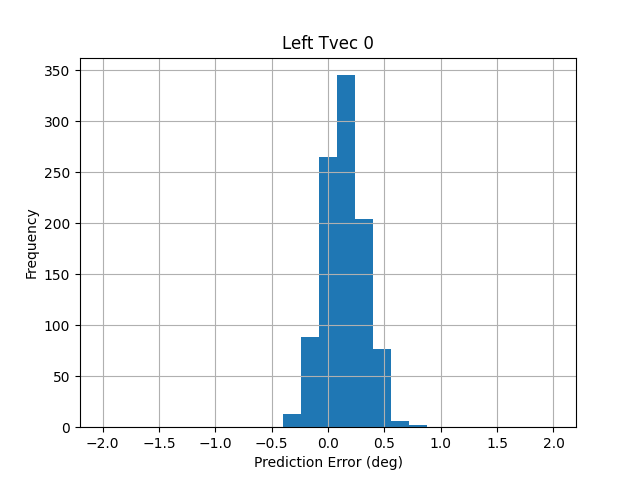

In [48]:
plt.figure()
plt.hist(np.degrees(data_df['delta_l_tvec_0']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Tvec 0')

/tmp/ipykernel_1391220/4092950716.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Text(0.5, 1.0, 'Left Tvec 1')

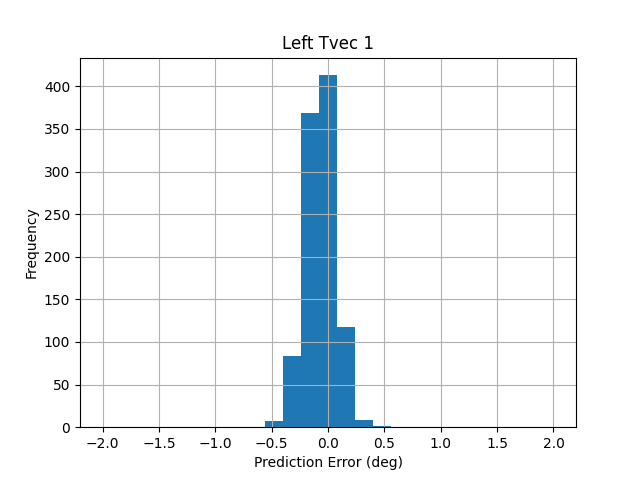

In [49]:
plt.figure()
plt.hist(np.degrees(data_df['delta_l_tvec_1']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Tvec 1')

Text(0.5, 1.0, 'Left Tvec 2')

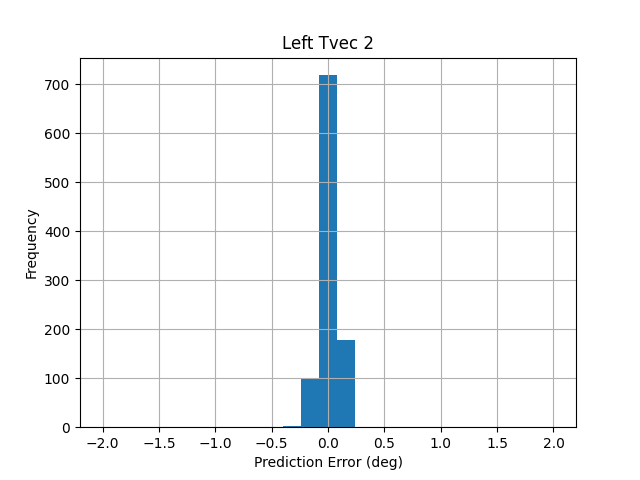

In [50]:
plt.figure()
plt.hist(np.degrees(data_df['delta_l_tvec_2']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Left Tvec 2')

Text(0.5, 1.0, 'Right Rvec 0')

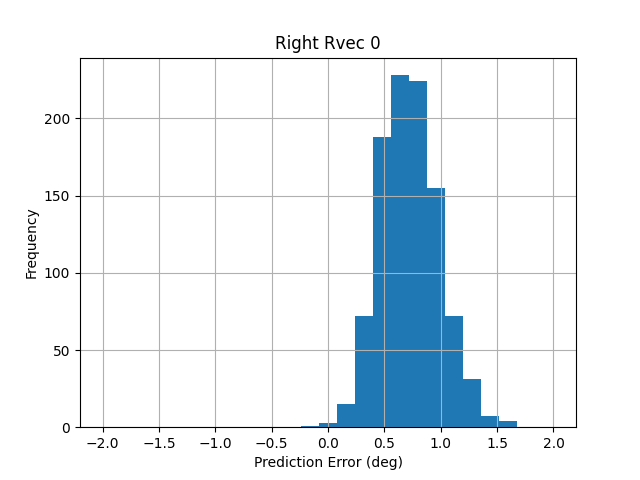

In [51]:
plt.figure()
plt.hist(np.degrees(data_df['delta_r_rvec_0']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Rvec 0')

Text(0.5, 1.0, 'Right Rvec 1')

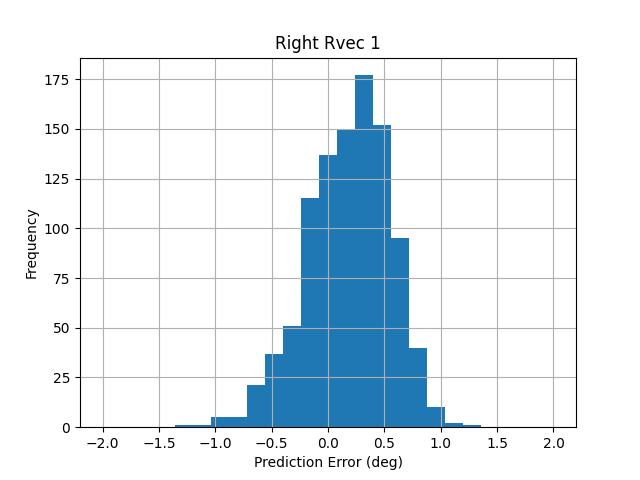

In [52]:
plt.figure()
plt.hist(np.degrees(data_df['delta_r_rvec_1']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Rvec 1')

Text(0.5, 1.0, 'Right Rvec 2')

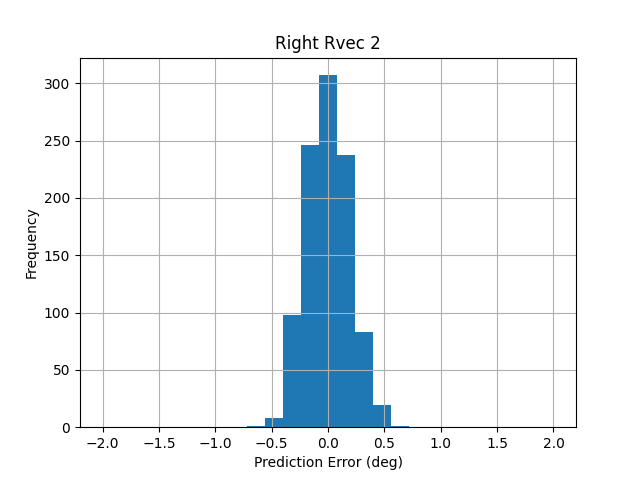

In [53]:
plt.figure()
plt.hist(np.degrees(data_df['delta_r_rvec_2']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Rvec 2')

Text(0.5, 1.0, 'Right Tvec 0')

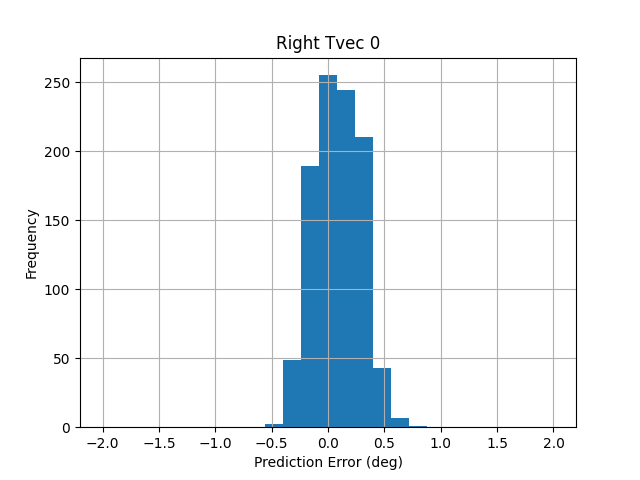

In [54]:
plt.figure()
plt.hist(np.degrees(data_df['delta_r_tvec_0']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Tvec 0')

Text(0.5, 1.0, 'Right Tvec 1')

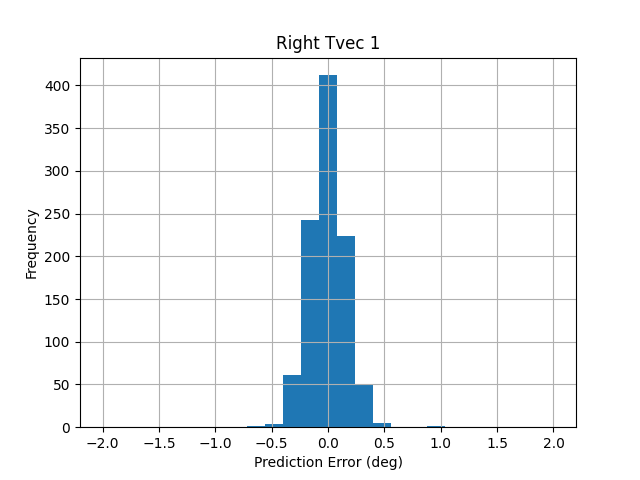

In [55]:
plt.figure()
plt.hist(np.degrees(data_df['delta_r_tvec_1']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Tvec 1')

Text(0.5, 1.0, 'Right Tvec 2')

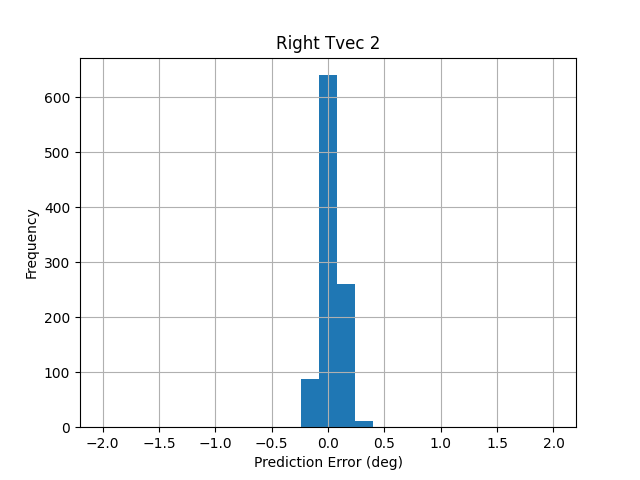

In [56]:
plt.figure()
plt.hist(np.degrees(data_df['delta_r_tvec_2']), bins=25, range=(-2,2))
plt.grid()
plt.xlabel('Prediction Error (deg)')
plt.ylabel('Frequency')
plt.title('Right Tvec 2')

In [57]:
# Input
idx = 100

# Left Camera
pred_l_rvec = np.array([data_df['pred_l_rvec_0'][idx],data_df['pred_l_rvec_1'][idx],data_df['pred_l_rvec_2'][idx]])
pred_l_tvec = np.array([data_df['pred_l_tvec_0'][idx],data_df['pred_l_tvec_1'][idx],data_df['pred_l_tvec_2'][idx]])
target_l_rvec =  np.array([data_df['target_l_rvec_0'][idx],data_df['target_l_rvec_1'][idx],data_df['target_l_rvec_2'][idx]])
target_l_tvec = np.array([data_df['target_l_tvec_0'][idx],data_df['target_l_tvec_1'][idx],data_df['target_l_tvec_2'][idx]])
pred_l_homo = vec2homo(pred_l_rvec, pred_l_tvec)
target_l_homo = vec2homo(target_l_rvec, target_l_tvec)
pred_l_homo_inv = np.linalg.inv(pred_l_homo)
target_l_homo_inv = np.linalg.inv(target_l_homo)

# Right Camera
pred_r_rvec = np.array([data_df['pred_r_rvec_0'][idx],data_df['pred_r_rvec_1'][idx],data_df['pred_r_rvec_2'][idx]])
pred_r_tvec = np.array([data_df['pred_r_tvec_0'][idx],data_df['pred_r_tvec_1'][idx],data_df['pred_r_tvec_2'][idx]])
target_r_rvec =  np.array([data_df['target_r_rvec_0'][idx],data_df['target_r_rvec_1'][idx],data_df['target_r_rvec_2'][idx]])
target_r_tvec = np.array([data_df['target_r_tvec_0'][idx],data_df['target_r_tvec_1'][idx],data_df['target_r_tvec_2'][idx]])
pred_r_homo = vec2homo(pred_r_rvec, pred_r_tvec)
target_r_homo = vec2homo(target_r_rvec, target_r_tvec)
pred_r_homo_inv = np.linalg.inv(pred_r_homo)
target_r_homo_inv = np.linalg.inv(target_r_homo)

print('Pred Left Cam:', pred_l_homo)
print('Target Left Cam:', target_l_homo)
print('Pred Right Cam:', pred_r_homo)
print('Target Right Cam:', target_r_homo)

Pred Left Cam: [[ 0.98526353 -0.03856183 -0.16663964 -0.01725971]
 [ 0.03439233  0.9990207  -0.0278359   0.2086127 ]
 [ 0.16754985  0.02169457  0.98562485 -0.01440393]
 [ 0.          0.          0.          1.        ]]
Target Left Cam: [[ 0.98548287 -0.04052226 -0.16486794 -0.01898007]
 [ 0.03465538  0.99866486 -0.0383087   0.20774987]
 [ 0.16620016  0.03203901  0.98557138 -0.01270283]
 [ 0.          0.          0.          1.        ]]
Pred Right Cam: [[ 0.87529552 -0.06788392 -0.47880006 -0.07817902]
 [ 0.07110129  0.99740362 -0.01143072  0.20467675]
 [ 0.47833285 -0.02403805  0.87784958 -0.05332147]
 [ 0.          0.          0.          1.        ]]
Target Right Cam: [[ 0.87352461 -0.07132334 -0.48152646 -0.07302779]
 [ 0.06830592  0.99738002 -0.02381918  0.20645192]
 [ 0.48196375 -0.01208447  0.87610781 -0.05323941]
 [ 0.          0.          0.          1.        ]]


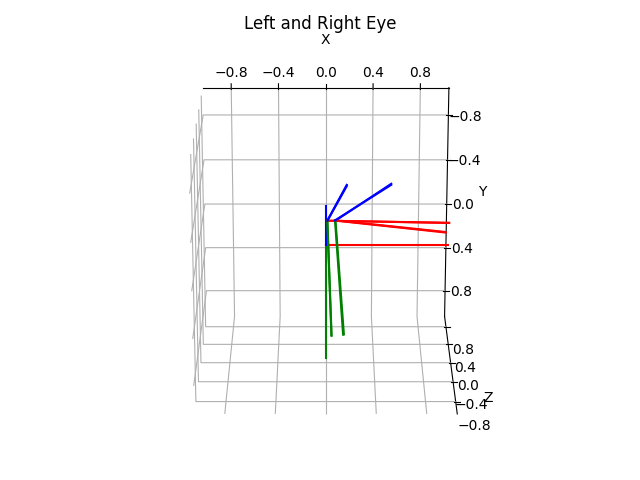

In [58]:
%matplotlib widget

# Plot
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = pr.plot_basis()

# Left Camera
ax = pr.plot_basis(R=pred_l_homo_inv[:3,:3], p=pred_l_homo_inv[:3,3].flatten())
ax = pr.plot_basis(R=target_l_homo_inv[:3,:3], p=target_l_homo_inv[:3,3].flatten())

# Right Camera
ax = pr.plot_basis(R=pred_r_homo_inv[:3,:3], p=pred_r_homo_inv[:3,3].flatten())
ax = pr.plot_basis(R=target_r_homo_inv[:3,:3], p=target_r_homo_inv[:3,3].flatten())

ax.view_init(elev=-70, azim=-90, roll=0)
ax.set_title('Left and Right Eye')
plt.tight_layout()